### [Story](https://www.pivotaltracker.com/story/show/187949220)
### [Source](https://goodboychan.github.io/python/deep_learning/tensorflow-keras/vision/2020/10/16/01-Image-Classification-with-Cat-and-Dog.html)

Create from scratch a CNN apllied to computer vision, to classify cats and dogs from a well known image dataset published in [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).

In [74]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

In [75]:
print(f"Tensorflow: v{tf.__version__}")

Tensorflow: v2.16.2


### Dataset Preparation

In [76]:
# Image load
def load(f, label):
    # load image into tensor
    image = tf.io.read_file(f)
    # Decode image into JPEG
    image = tf.image.decode_jpeg(image)
    # convert it to tf.float32
    image = tf.cast(image, tf.float32)

    return image, label

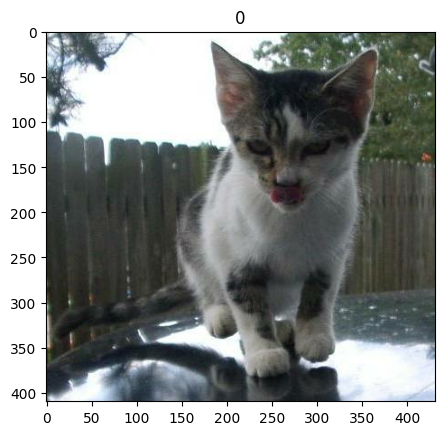

In [77]:
# test load()
image, label = load('data/dogs-vs-cats/train/cat.11.jpg', 0)
fig, ax = plt.subplots()
ax.imshow(image /255.)
ax.set_title(label)
plt.show()

In [78]:
def resize(input_image, size):
    return tf.image.resize(input_image, size)

In [80]:
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150,150,3])

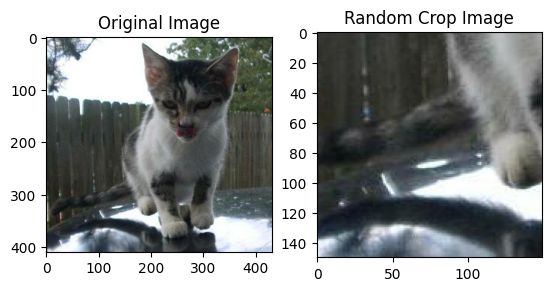

In [82]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Random Crop Image")
plt.show()

In [83]:
def central_crop(input_image):
    image = resize(input_image, [176,176])
    return tf.image.central_crop(image, central_fraction=0.84)    

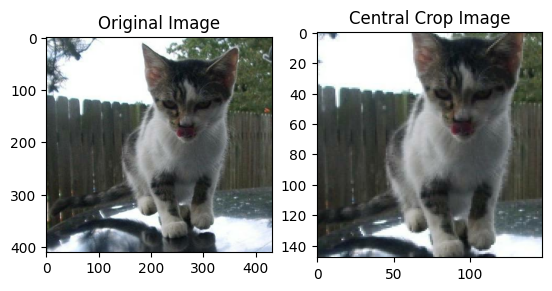

In [84]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(central_crop(image) / 255.)
ax[1].set_title("Central Crop Image")
plt.show()

In [85]:
def random_rotation(input_image):
    angles = np.random.randint(0,3,1)
    return tf.image.rot90(input_image, k=angles[0])

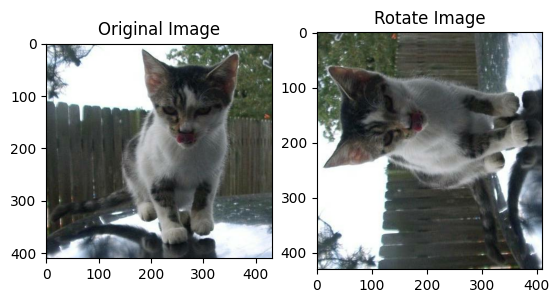

In [86]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_rotation(image) / 255.)
ax[1].set_title("Rotate Image")
plt.show()

In [87]:
def random_jitter(input_image):
    # Resize
    image = resize(input_image, [176,176])
    # Random crop
    image = random_crop(image)
    # random rotation
    image = random_rotation(image)
    # random mirror
    image = tf.image.random_flip_left_right(image)
    return image

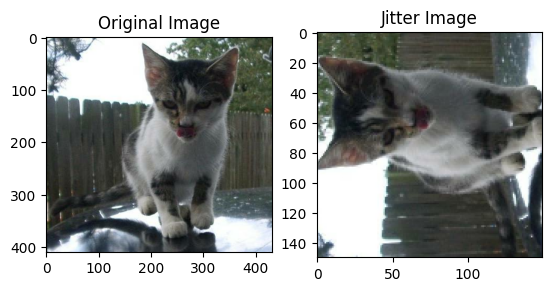

In [88]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_jitter(image) / 255.)
ax[1].set_title("Jitter Image")
plt.show()

In [89]:
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image

In [90]:
def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

In [92]:
def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

### Data Pipleline

In [118]:
d = os.path.join('dataset', 'dogs-vs-cats','*.jpg')

print (d)
#temp_ds = tf.data.Dataset.list_files(os.path.join('dataset', 'dogs-vs-cats','*.jpg'))

dataset/dogs-vs-cats/*.jpg


In [ ]:
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1,10,figsize=(20,6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image,0 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()